*Aprenentatge Computacional*  
- Zakaria Boudich Makran (1672001)

# Pràctica - Google Play Store Apps

En aquesta pràctica s'abordarà la creació d'un model per tal de predir el nombre de descàrregues que tindrà una aplicació mòbil, representat per l'atribut *installs*. Seguirem una sèrie de passos per obtenir el resultat, primer analitzarem les dades, les preprocessarem, s'escollirà les mètriques i els diferents models per així aconseguir el millor classificador.

## 0. Importació de llibreries 

Importem les llibreries necessàries per a la manipulació, visualització i anàlisi de dades ⚙️

In [31]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

# LLIBRERIA PER GESTIONAR I MANIPULAR DATES I HORES 
from datetime import datetime

# LlIBRERIA QUE ENS PERMET TREBALLAR AMB EXPRESSIONS REGULARS
import re

import warnings

# Suprimir todos los warnings
warnings.filterwarnings('ignore')

## 1. EDA (exploratory data analysis) 

En aquest apartat, realitzarem una anàlisi exploratòria de les dades, on examinarem les característiques del conjunt de dades, buscarem patrons i visualitzarem la distribució de les variables. 

En aquest cas, ens ve donat **dos conjunts de dades**. L'objectiu serà unir-los per aprofitar els atributs més rellevants de cadascun i utilitzar-los en l'entrenament del model. Ara farem una breu descripció de cada conjunt de dades:

**1. Dataset de les aplicacions (Apps):** 📲  
* Conté informació sobre les aplicacions a la Google Play Store, com el nom, la categoria, la valoració mitjana, el nombre d'instal·lacions, el preu, etc.  
* Aquest conjunt de dades ens permet entendre les característiques bàsiques de cada aplicació i el seu rendiment a la botiga.

**2. Dataset de les ressenyes (Reviews):** ⭐ 
* Conté les opinions dels usuaris sobre les aplicacions anteriors. Cada ressenya inclou la valoració que l'usuari ha donat a l'aplicació, comentari de l'usuari, etc. 
* Aquest conjunt de dades és útil per estudiar el sentiment dels usuaris i com les valoracions individuals poden influir en la valoració general de l'aplicació.

**Per simplicitat**, primer tractarem el dataset d'aplicacions i després el de les ressenyes.


### 1.1. Anàlisis del dataset de les aplicacions

#### 1.1.1. Descripció dels atributs


In [32]:
apps_data = pd.read_csv("data/aplicacions.csv")
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [33]:
print("El nombre de mostres que tenim a la base de dades és de", apps_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", apps_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 10841
El nombre de atributs que tenim a la base de dades és de 13


Es pot veure que disposem de 13 atributs diferents amb un total de 10841 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [34]:
print("Informació de cada atribut:")
print(apps_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None


La base de dades conté 13 atributs on es descriu les característiques de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació.  
- **Category (Objecte):** Categoria de l'aplicació.  
- **Rating (Float64):** Valoració mitjana de l'aplicació (valor de 1 a 5).  
- **Reviews (Objecte):** Nombre de ressenyes que té l'aplicació. 
- **Size (Objecte):** Mida de l'aplicació en megabytes (Pot incloure unitats com 'M' o 'k'). Si la mida depèn del dispositiu s'utilitza l'expressió "Varies with devices".
- **Installs (Objecte):** Nombre d'instal·lacions de l'aplicació. (Inclou el caràcter +)
- **Type (Objecte):** Si l'aplicació és gratuïta o de pagament.  
- **Price (Objecte):** El preu de l'aplicació (si és de pagament). S'inclou el símbol '$', indicant que el preu esta en dòlars. 
- **Content Rating (Objecte):** Classificació per contingut (per exemple, "Tots els públics", "Adolescents", etc.).  
- **Genres (Objecte):** Gèneres de l'aplicació (com "Acció", "Educació", etc.).  
- **Last Updated (Objecte):** La data de l'última actualització de l'aplicació indica quan es va modificar per última vegada. Es presenta en el format "MMMM DD, YYYY".
- **Current Ver (Objecte):** Versió actual de l'aplicació.  
- **Android Ver (Objecte):** Versió d'Android compatible amb l'aplicació.



#### 1.1.2. Detecció de valors nuls

A continuació mostrarem el nombre de NaNs per cada atribut:


In [35]:
print(apps_data.isnull().sum()[apps_data.isnull().sum() > 0])

Rating            1474
Type                 1
Content Rating       1
Current Ver          8
Android Ver          3
dtype: int64


Podem observar la aparició de valors nuls en els atributs següents: *Rating*, *Current Ver*, *Android Ver* i *Type*. D'aquests atributs el més significatiu és el *Rating*, obtenint un percentatge de NaNs proper el 15%.\
A continuació, el que farem és imprimir algunes files del dataset on el *Rating* tingui un valor NaN, per veure si mitjançant els altres atributs, podem determinar si els valors nuls del atribut *Rating* tenen algun significat o son a causa d'algun error. 

In [36]:
null_ratings = apps_data[apps_data['Rating'].isnull()]
print(null_ratings.head().to_string(index=False))

                                App       Category  Rating Reviews Size Installs Type Price Content Rating                          Genres       Last Updated Current Ver Android Ver
             Mcqueen Coloring pages ART_AND_DESIGN     NaN      61 7.0M 100,000+ Free     0       Everyone Art & Design;Action & Adventure      March 7, 2018       1.0.0  4.1 and up
          Wrinkles and rejuvenation         BEAUTY     NaN     182 5.7M 100,000+ Free     0   Everyone 10+                          Beauty September 20, 2017         8.0  3.0 and up
             Manicure - nail design         BEAUTY     NaN     119 3.7M  50,000+ Free     0       Everyone                          Beauty      July 23, 2018         1.3  4.1 and up
       Skin Care and Natural Beauty         BEAUTY     NaN     654 7.4M 100,000+ Free     0           Teen                          Beauty      July 17, 2018        1.15  4.1 and up
Secrets of beauty, youth and health         BEAUTY     NaN      77 2.9M  10,000+ Free     

Com es pot veure, tot indica que els valors nuls de l'atribut *Rating* son errors a la hora de crear el dataset o per una altre raó que desconeixem, ja que les aplicacions que és mostren, el nombre de ressenyes (*reviews*) és major a zero, però tot i així apareix un valor nul en l'atribut *Rating*. 

#### 1.1.3. Detecció de dades anomals

En aquest apartat, comprovarem que alguns atributs del dataset no continguin valors anòmals (outliers) no detectats inicialment, considerant-ne els resultats principalment pel *preprocessing* dels atributs. S'ha de tenir en compte que no considerarem els valors nuls com a valors anomals, ja que els hem tractat anteriorment.\
Començarem verificant els atributs que considera la llibreria Pandas com a numèrics, i posteriorment passarem als categòrics. 

**1. Atributs numèrics: 🔢** 
- **Rating:** Verifiquem que no tinguem valors negatius o valors fora del rang [1, 5].

In [37]:
print(f"Rating - Min: {apps_data['Rating'].min()}, Max: {apps_data['Rating'].max()}")

Rating - Min: 1.0, Max: 19.0


Com podem veure, tot i que no tenim valors negatius, ens aparèix un valor fora del rang [1,5]. Per entrar en l'arrel del problema, visualitzarem les files que contenen valors majors a 5 en l'atribut:

In [38]:
incorrect_ratings = apps_data[apps_data['Rating'] > 5]
print(incorrect_ratings.to_string(index=False))

                                    App Category  Rating Reviews   Size Installs Type    Price Content Rating            Genres Last Updated Current Ver Android Ver
Life Made WI-Fi Touchscreen Photo Frame      1.9    19.0    3.0M 1,000+     Free    0 Everyone            NaN February 11, 2018       1.0.19  4.0 and up         NaN


La sortida anterior, ens indica que hi ha una fila on els valors dels atributs no estan correctament assignats. Per exemple, veiem que el nombre de descargues de l'aplicació, que en aquest cas és 1000, no està inserit en l'atribut *Installs* (que és on hauria d'estar), sino en l'atribut *Size*. Amb altres atributs d'aquesta fila ens passa el mateix. Com a cas especial, per no veure el mateix error en les comprovacions següents, corregirem manualment aquesta fila:

In [39]:
apps_data.loc[10472] = ['Life Made Wi-Fi Touchscreen Photo Frame', 'PHOTOGRAPHY', 1.9, 19.0, '3.0MB', '1,000+', 'Free', 0, 'Everyone', 'Photography', 'February 11, 2018', '1.0.19', '4.0 and up']

**2. Atributs categòrics: 🏷️** 

- **Last Updated**: Com a verificació, ens assegurarem que les dates segueixin un patró de format bàsic. En aquest cas, que el primer element sigui una paraula per al mes, seguit d’un número per al dia (de 1 o 2 dígits), i un any de quatre dígits. Per aconseguir-ho, ens ajudarem de les expresions regulars. En la sortida imprimirem les dates que no siguin vàlides.

In [40]:
date_pattern = r"^[A-Za-z]+ \d{1,2}, \d{4}$"
invalid_dates = apps_data[~apps_data["Last Updated"].str.match(date_pattern, na=False)]
print(invalid_dates["Last Updated"])

Series([], Name: Last Updated, dtype: object)


Com que la llista és buida, podem dir que les dates contenides en l'atribut tenen un format bàsic vàlid. 

- **Reviews**, **Installs**, **Price**: Tot i que Pandas ha assignat aquests atributs com a categòrics, per la seva naturaleza els podem considerar com a numèrics. Com s'ha fet per l'atribut *Rating*, agafarem el valor mínim de cada atribut per detectar si tenim valors negatius. Com a casos especials, per a trobar el mínim de l'atribut *Installs* i *Price*, abans haurem d'eliminar algun caràcter present en els seus valors. Per exemple, en l'atribut *Price* ens hi pot aparèixer el caràcter "$".

In [41]:
reviews_summary = pd.to_numeric(apps_data["Reviews"], errors='coerce').describe()
print(f"Reviews - Min: {reviews_summary['min']}")

#Eliminem el caràcter "+" dels valors presents en l'atribut Installs
apps_data["Installs"] = apps_data["Installs"].replace('+', '')
installs_summary = pd.to_numeric(apps_data["Installs"], errors='coerce').describe()
print(f"Installs - Min: {installs_summary['min']}")

#Eliminem el caràcter "$" dels valors presents en l'atribut Price
apps_data["Price"] = apps_data["Price"].replace('$', '')
installs_summary = pd.to_numeric(apps_data["Price"], errors='coerce').describe()
print(f"Price - Min: {installs_summary['min']}")

Reviews - Min: 0.0
Installs - Min: 0.0
Price - Min: 0.0


Com que el valor mínim per cada atribut és 0, podem dir que no hi tenim valors negatius. 

- **Type**, **Content Rating**, **Category**, **Genres**: Realitzarem una revisió manual per assegurar-nos que hi hagi categories coherents per a cada atribut.

In [42]:
print("Type")
print(apps_data["Type"].unique())
print()

print("Content Rating")
print(apps_data["Content Rating"].unique())
print()

print("Category")
print(apps_data["Category"].unique())
print()

print("Genres")
print(apps_data["Genres"].unique())
print()

Type
['Free' 'Paid' nan]

Content Rating
['Everyone' 'Teen' 'Everyone 10+' 'Mature 17+' 'Adults only 18+' 'Unrated']

Category
['ART_AND_DESIGN' 'AUTO_AND_VEHICLES' 'BEAUTY' 'BOOKS_AND_REFERENCE'
 'BUSINESS' 'COMICS' 'COMMUNICATION' 'DATING' 'EDUCATION' 'ENTERTAINMENT'
 'EVENTS' 'FINANCE' 'FOOD_AND_DRINK' 'HEALTH_AND_FITNESS' 'HOUSE_AND_HOME'
 'LIBRARIES_AND_DEMO' 'LIFESTYLE' 'GAME' 'FAMILY' 'MEDICAL' 'SOCIAL'
 'SHOPPING' 'PHOTOGRAPHY' 'SPORTS' 'TRAVEL_AND_LOCAL' 'TOOLS'
 'PERSONALIZATION' 'PRODUCTIVITY' 'PARENTING' 'WEATHER' 'VIDEO_PLAYERS'
 'NEWS_AND_MAGAZINES' 'MAPS_AND_NAVIGATION']

Genres
['Art & Design' 'Art & Design;Pretend Play' 'Art & Design;Creativity'
 'Art & Design;Action & Adventure' 'Auto & Vehicles' 'Beauty'
 'Books & Reference' 'Business' 'Comics' 'Comics;Creativity'
 'Communication' 'Dating' 'Education;Education' 'Education'
 'Education;Creativity' 'Education;Music & Video'
 'Education;Action & Adventure' 'Education;Pretend Play'
 'Education;Brain Games' 'Entertainment

Segons la sortida anterior podem veure que tenim categories coherents amb la temàtica del dataset.

#### 1.1.4. Plantejament de la selecció i creació de nous atributs

Havent finalitzat l'anàlisi del conjunt de dades d'aplicacions, procedirem a l'anàlisi del conjunt de dades de les ressenyes.

### 1.2. Anàlisis del dataset de les ressenyes

#### 1.2.1. Descripció dels atributs

In [43]:
reviews_data = pd.read_csv("data/ressenyes.csv")
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [44]:
print("El nombre de mostres que tenim a la base de dades és de", reviews_data.shape[0])
print("El nombre de atributs que tenim a la base de dades és de", reviews_data.shape[1])

El nombre de mostres que tenim a la base de dades és de 64295
El nombre de atributs que tenim a la base de dades és de 5


Es pot veure que disposem de 5 atributs diferents amb un total de 64295 mostres, que utilitzarem per entrenar el nostre model i predir la variable objectiu. A continuació, analitzarem detalladament cada atribut per entendre millor el seu significat i la seva possible influència en la predicció del nombre de descàrregues d'una aplicació.


In [45]:
print("Informació de cada atribut:")
print(reviews_data.info())

Informació de cada atribut:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB
None


El conjunt de dades conté 5 atributs on es descriu les característiques de reviews de cada aplicació. A continuació es fa una breu descripció de cada *feature*:

- **App (Objecte):** Nom de l'aplicació a la qual pertany la ressenya. Ens serveix com enllaç del dataset anterior. 
- **Translated_Review (Objecte):** Comentari de l'usuari de l'aplicació traduït a l'anglès. Pot contenir valors nuls si no hi ha comentari. 
- **Sentiment (Objecte):** Categoria del sentiment expressat en el comentari de l'usuari (per exemple, "Positiu", "Negatiu" o "Neutral").  
- **Sentiment_Polarity (Float64):** Mesura de polaritat del sentiment del comentari de l'usuari, amb valors entre -1 (molt negatiu) i 1 (molt positiu).  
- **Sentiment_Subjectivity (Float64):** Mesura de subjectivitat del comentari de l'usuari, amb valors entre 0 (totalment objectiu) i 1 (totalment subjectiu). 

#### 1.2.2. Detecció de valors nuls

Segons la sortida anterior podem veura una gran quantitat de valors nuls en les característiques, excepte l'atribut *App*. Anem a veure la distribució per cada atribut:

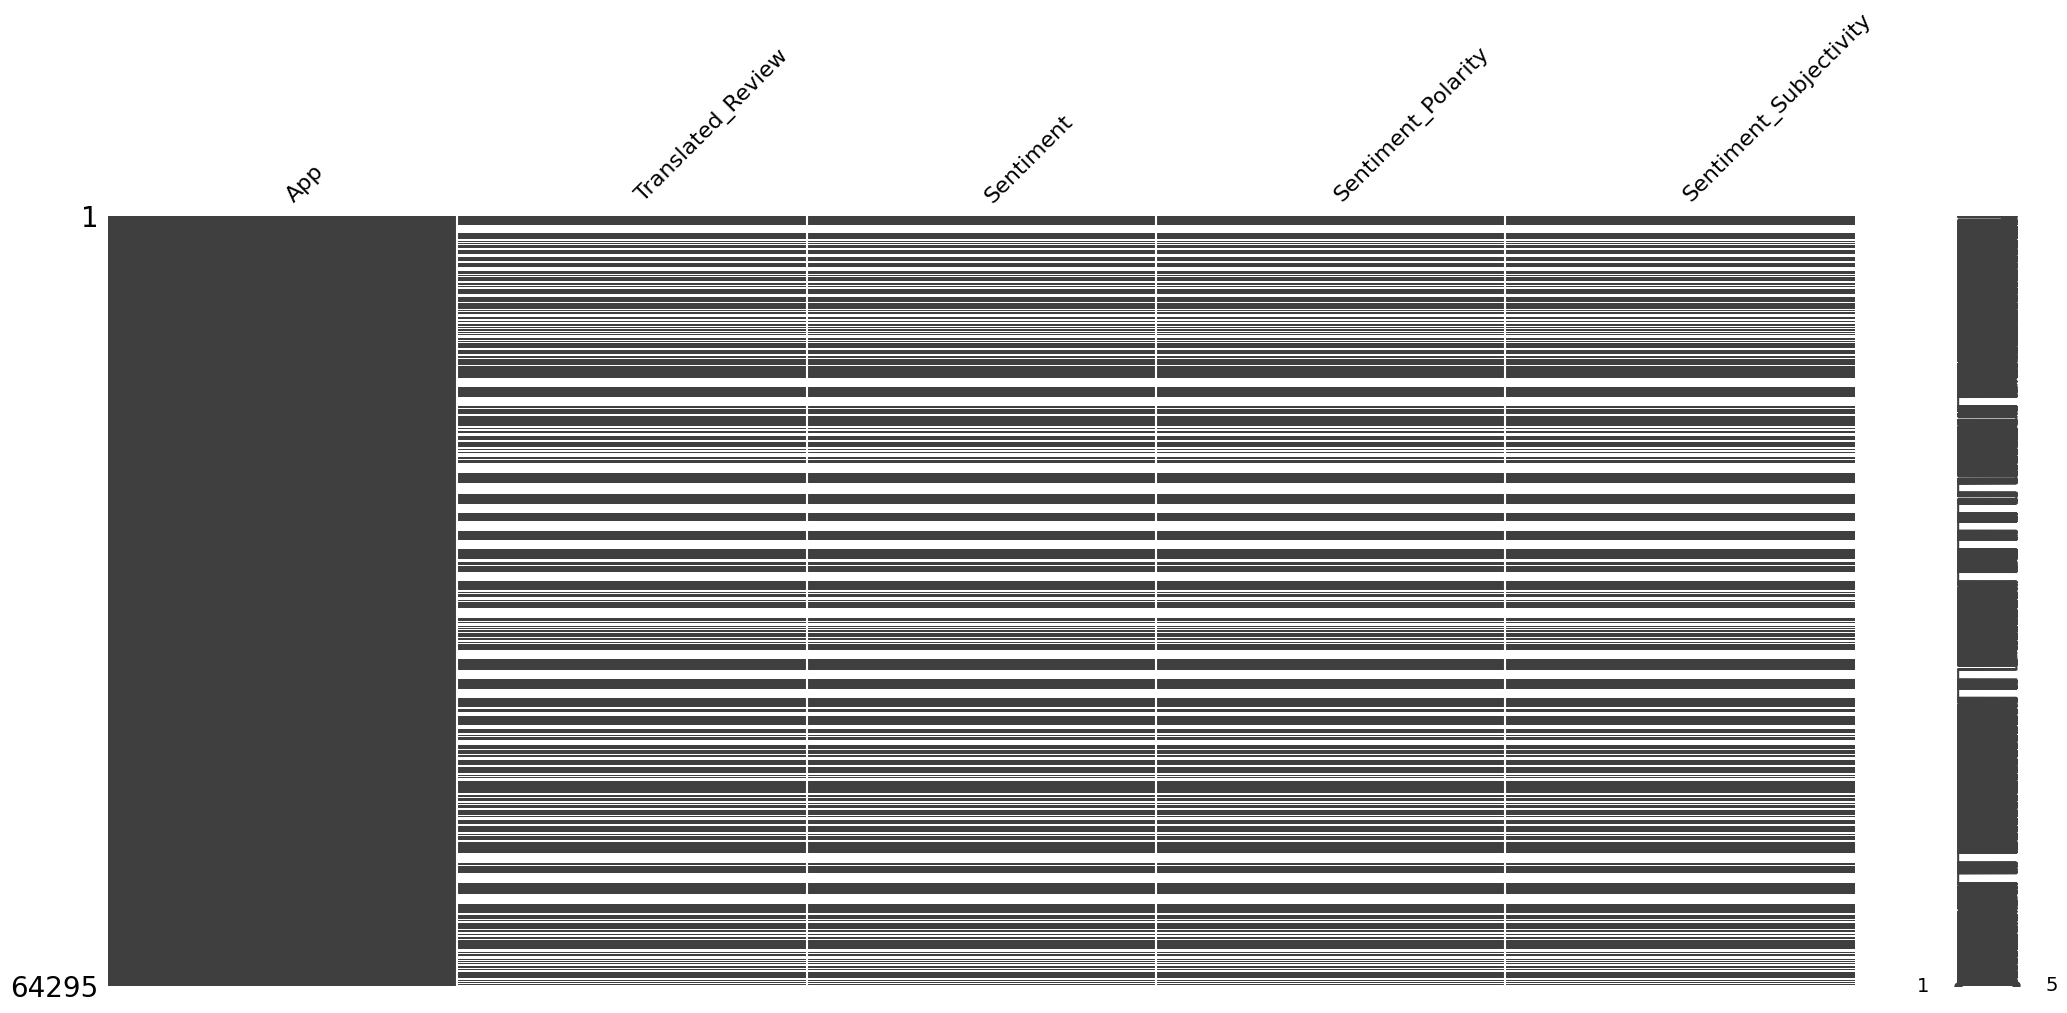

In [46]:
msno.matrix(reviews_data)
plt.show()

Com podem observar, hi ha una forta dependència entre els atributs *Translated_Review*, *Sentiment*, *Sentiment_Polarity* i *Sentiment_Subjectivity* pel que fa als valors nuls. Entenem que la causa de tot això és l'atribut *Translated_Review*, ja que l'ànalisi del sentiment requereix que l'usuari hagi escrit un text per a la seva ressenya. Podem concloure, que els valors nuls en aquest cas tenen un significat concret.

Per entrar més en detall, crearem un gràfic que mostri el percentatge de valors nuls en els comentaris de cada aplicació, en funció del nombre total de comentaris de cada una.

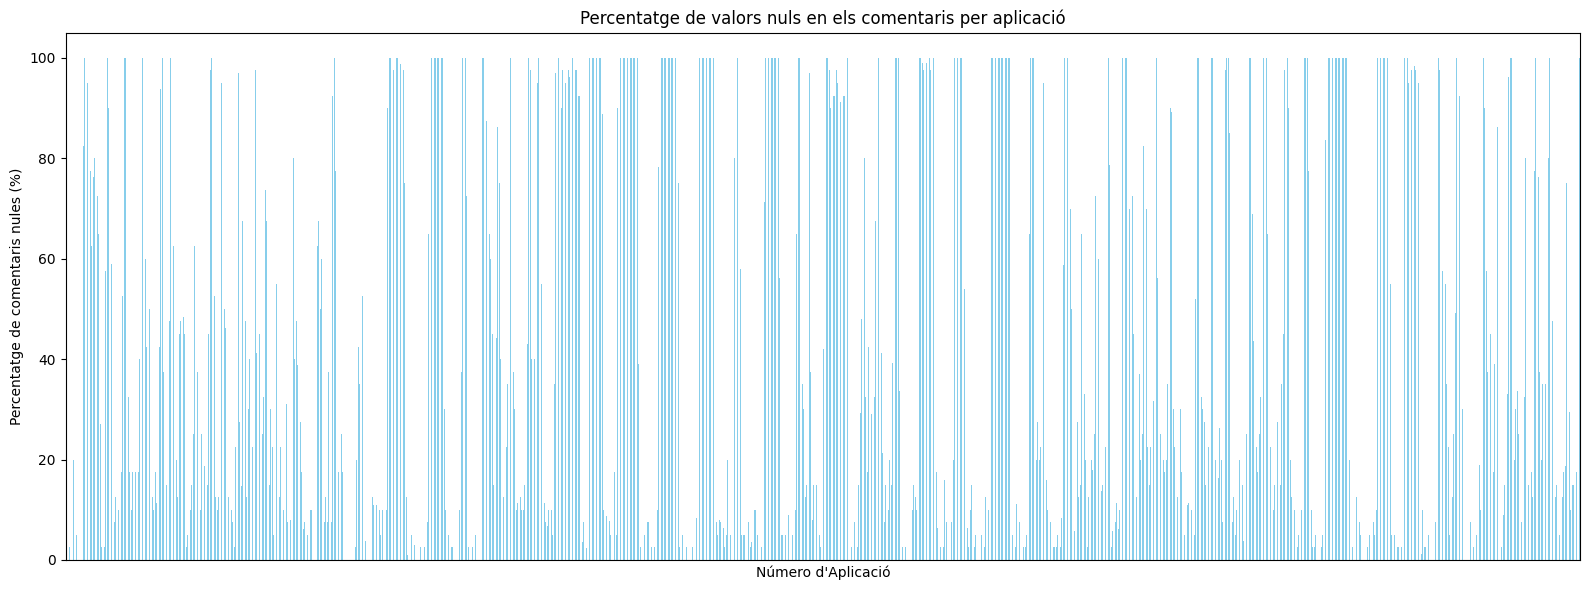

In [47]:
grouped_data = reviews_data.groupby('App')
nans_in_reviews = grouped_data['Translated_Review'].agg(lambda x: x.isna().sum())
total_reviews = grouped_data['Translated_Review'].count() + nans_in_reviews
nan_percentage = (nans_in_reviews / total_reviews) * 100

plt.figure(figsize=(16, 6)) 
nan_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentatge de valors nuls en els comentaris per aplicació')
plt.xlabel('Número d\'Aplicació')
plt.ylabel('Percentatge de comentaris nules (%)')
plt.xticks([])  

plt.subplots_adjust(left=0.05, right=0.95) 
plt.tight_layout()
plt.show()

Segons el gràfic, podem observar que una gran majoria d'aplicacions no contenen comentaris. Per quantificar-ho millor, a continuació calcularem el percentatge d'aplicacions que no contenen comentaris segons el total d'aplicacions:

In [48]:
aplicacions_sense_resenyes = (nan_percentage == 100).sum()
total_aplicacions = len(nan_percentage)
percentatge_sense_resenyes = (aplicacions_sense_resenyes / total_aplicacions) * 100
percentatge_sense_resenyes = round(percentatge_sense_resenyes, 2)
print(f'Percentatge d\'aplicacions sense ressenyes: {percentatge_sense_resenyes}%')

Percentatge d'aplicacions sense ressenyes: 19.46%


Segons el càlcul anterior, el 19% d'aplicacions no contenen comentaris.

#### 1.2.3. Detecció de dades anomals

Com en el dataset *apps* comprovarem que els atributs no tinguin valors anòmals (*outliers*) que no hàgim detectat a primera vista. Començarem verificant els atributs categòrics, i posteriorment passarem als numèrics.  

**1. Atributs categòrics: 🏷️** 

- **App:** Comprovarem que tot nom d'aplicació del dataset *reviews* estigui present en el conjunt de dades *apps*. En percentatge expressarem el nombre d'aplicacions del dataset *reviews* que no estiguin present en el dataset *apps*. 

In [49]:
apps_set = set(apps_data['App'])
reviews_set = set(reviews_data['App'])
missing_apps = apps_set - reviews_set
missing_apps_count = len(missing_apps)
print(f"{(missing_apps_count / len(apps_set)) * 100:.2f}%")


89.44%


Segons el resultat anterior, podem veure que hi han aplicacions en el dataset *ressenyes* que no estan contingudes en el dataset *apps*, concretament un 89%.


- **Sentiment:** Verificarem que no tinguem una categoria anomala, o una categoria que no s'hagi contemplat a primera vista.

In [50]:
sentiment_counts = reviews_data['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    23998
Negative     8271
Neutral      5163
Name: count, dtype: int64


En aquest cas tenim les categories Positive, Negative i Neutral. No s'observa ningun cas extrany. 

**1. Atributs numèrics: 🔢** 
- **Sentiment_Polarity, Sentiment_Subjectivity:** Verificarem que no tinguem presents valors fora de rang dels respectius atributs. 

In [51]:
polarity_summary = reviews_data['Sentiment_Polarity'].describe()
subjectivity_summary = reviews_data['Sentiment_Subjectivity'].describe()

print(f"Sentiment_Polarity - Min: {polarity_summary['min']}, Max: {polarity_summary['max']}")
print(f"Sentiment_Subjectivity - Min: {subjectivity_summary['min']}, Max: {subjectivity_summary['max']}")

Sentiment_Polarity - Min: -1.0, Max: 1.0
Sentiment_Subjectivity - Min: 0.0, Max: 1.0


Podem comprovar pels dos atributs, que no ens apareix ningun valor fora de rang

## 2. Preprocessing 

En aquest apartat, es duran a terme tres etapes per preparar els atributs: tractament dels valors nuls, codificació de les variables categòriques i normalització dels valors numèrics. A més, crearem nous atributs que milloraran la capacitat del model per identificar patrons. 

Cal dir que, el dataset *reviews* es descartarà de bon principi per entrenar el model. Tot i que conté atributs que poden aportar informació al model, presenta diverses limitacions importants. En primer lloc, podem veure que el dataset *reviews* només inclou el 10% de les aplicacions que estan presents al dataset *apps*, com s'ha vist en l'apartat de detecció d'anomalies. A més, segons l'anàlisi de valors nuls, de les aplicacions presents en el dataset *reviews*, un 20% no tenen cap comentari registrat per l'usuari. Això provoca que la utilització del dataset *reviews* sigui inviable per entrenar el model.\


Per comoditat, s'anomenarà el dataset *apps* com a *train_data*, indicant implicitament que aquest dataset contindrà els atributs definitius per entrenar el model. 

### 1.2. Tractament de valors nuls

En aquest apartat, tractarem els valors nuls que ens apareixen en el dataset *apps*. Com s'ha vist en la detecció de valors nuls, ens apareixen valors nuls principalment en l'atribut *Rating*, seguidament dels atributs *Current Ver*, *Android Ver* i *Type*. Com a recordatori, a continuació s'imprimeix el nombre de valors nuls dels atributs esmentats:

In [ ]:
nan_counts = apps_data.isnull().sum()
nan_columns = nan_counts[nan_counts > 0]
sorted_nulls = nan_columns.sort_values(ascending=False)
print(sorted_nulls)

Rating         1474
Current Ver       8
Android Ver       2
Type              1
dtype: int64


Ara tractarem els valors numèrics, en aquest cas l'únic que tenim és l'atribut *Rating*, i a continuació els atributs de tipus categòric. 
Per inserir els valors nuls, podem optar per aplicar la mitjana o la mediana de les dades, depenent de la variança de les dades. Sabem que, en atributs amb una alta variació, la mitjana no ens pot donar un valor representatiu de les dades. Per quantificar aquesta variabilitat, farem servir el coeficient de variació. Si el coeficient és alt, els valors nuls s'inseriran aplicant la mediana. En cas contrari, si el coeficient és baix, els valors nuls s'inseriran aplicant la mitjana. Seguint la convenció, considerarem que un coeficient de variació major al 20% indica que la variació de les dades és alta. 

In [55]:
mean_rating = apps_data['Rating'].mean()
std_rating = apps_data['Rating'].std()
cv_rating = (std_rating / mean_rating) * 100
print("Coeficient de variació de l'atribut Rating:", cv_rating)

Coeficient de variació de l'atribut Rating: 11.437166706548235


Com veiem, la variació es pot considerar baixa, concretament un 11%. Per aquesta raó, a continuació emplenarem els valors nuls de l'atribut *Rating* utilitzant la mitjana:

In [56]:
mean_rating = apps_data['Rating'].mean()
apps_data['Rating'] = apps_data['Rating'].fillna(mean_rating)

Pels atributs categòrics, els valors nuls els emplenarem amb la categoria més freqüent de la columna, és a dir, utilitzant la moda.

In [58]:
apps_data['Current Ver'] = apps_data['Current Ver'].fillna(apps_data['Current Ver'].mode()[0])
apps_data['Android Ver'] = apps_data['Android Ver'].fillna(apps_data['Android Ver'].mode()[0])
apps_data['Type'] = apps_data['Type'].fillna(apps_data['Type'].mode()[0])

Ja acabat el tractament de nans, en la següent secció ens centrarem en codificar les variables de tipus categòric.  